# Detección de anomalías: Análisis de fraudes en tarjetas de crédito

#### Introducción:
La detección de anomalías es una técnica que se utiliza para identificar patrones inusuales que no se ajustan al comportamiento esperado, llamados valores atípicos.

Utilizaremos la detección de fraudes con tarjetas de crédito como el caso de estudio para comprender este concepto en detalle.

Para esta detección es importante entender la clasificación de anomalías, como:
- Anomalías puntuales: Una sola instancia de datos es anómala si está demasiado lejos del resto. 
- Anomalías contextuales: La anomalía es específica del contexto. Este tipo de anomalía es común en los datos de series de tiempo. 
- Anomalías colectivas: Un conjunto de instancias de datos ayuda colectivamente a detectar anomalías.

En este jupyter notebook vamos a tomaar la detección de fraude con tarjetas de crédito como el caso de estudio utilizando las siguientes técnicas de detección de detección de anomalías:
- Algoritmo de bosque de aislamiento o Insolation forest
- Algoritmo de detección de anomalías basado en densidad o Density-Based Anomaly Detection (Local Outlier Factor)

#### Declaración del problema de detección de fraudes con tarjetas de crédito
El problema de detección de fraudes con tarjetas de crédito incluye el modelado de transacciones pasadas con tarjetas de crédito con el conocimiento de las que resultaron ser fraudes. Luego, este modelo se utiliza para identificar si una nueva transacción es fraudulenta o no. Nuestro objetivo es detectar el 100% de las transacciónes fraudulentas minimizando las clasificaciones de fraude incorrectas.

#### DataSet: https://www.kaggle.com/mlg-ulb/creditcardfraud
*Observaciones*: El conjunto de datos está muy sesgado y consta de 492 fraudes en un total de 284.807 observaciones. Esto resultó en solo un 0,172% de casos de fraude. Este conjunto sesgado se justifica por el bajo número de transacciones fraudulentas.

El conjunto de datos consta de valores numéricos de las 28 características transformadas del "Análisis de componentes principales (PCA)", a saber, V1 a V28. Además, no hay metadatos sobre las características originales proporcionadas, por lo que no se pudo realizar un análisis previo o un estudio de características.
- Las categorias "Time" y "Amount" no son datos transformados.
- No falta ningún valor en el conjunto de datos.


In [2]:
 !pip install chart-studio
 import chart_studio.plotly as py

In [3]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import sklearn
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot

In [4]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data1= data.sample(frac = 0.1,random_state=1)
data1.shape

(28481, 31)

In [6]:
#Comprovando los valores perdidos
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

De la tabla anterior - No existen valores perdidos o nulos en el dataset 

In [7]:
#Calculamos las estadisticas de los datos
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


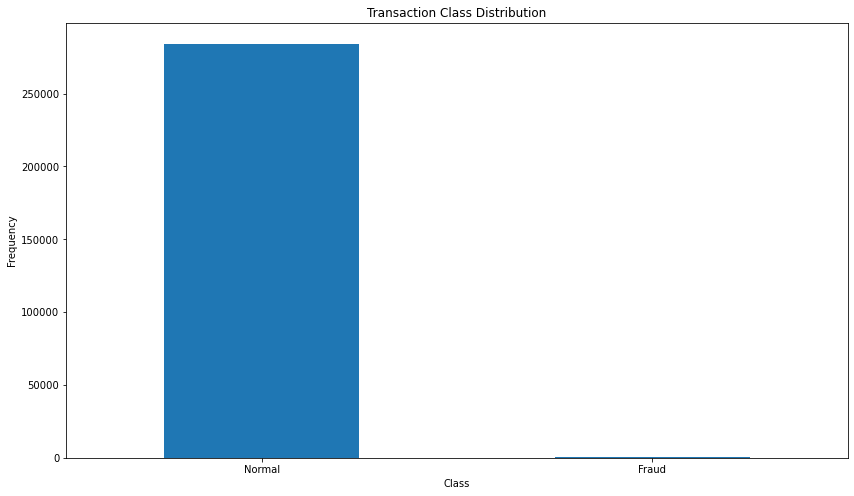

In [8]:
#Determinamos el número de fraudes y transacciones válidas en todo el conjunto de datos
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [9]:
#Clasificamos las clases de transacciones "0 = Normal y 1 = Fraude"
Normal = data[data['Class']==0]
Fraud = data[data['Class']==1]

In [10]:
Normal.shape

(284315, 31)

In [11]:
Fraud.shape

(492, 31)

#### Diferencia entre las cantidades de dinero en las diferentes clases de transacciones

In [12]:
Normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
Fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

#### Visualización de los datos

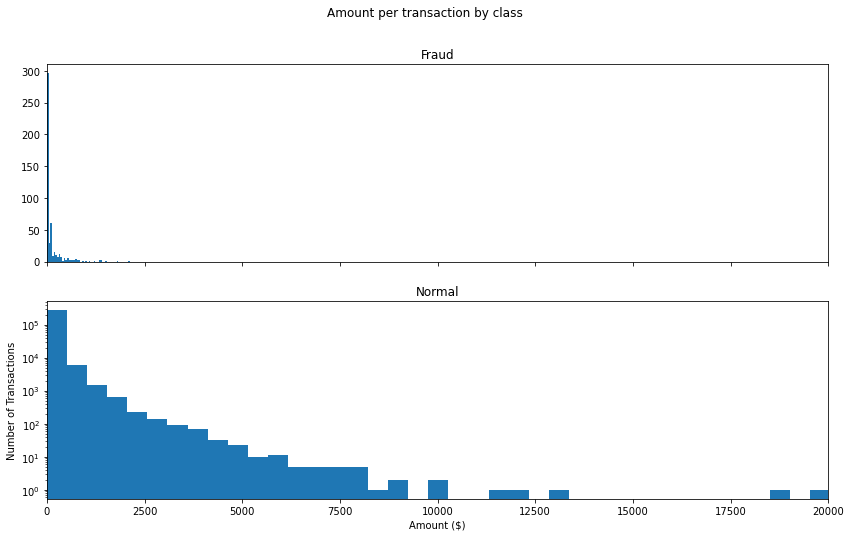

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

#### Ocurrencia de las transacciones fraudulentas de acuerdo a los periodos de tiempo

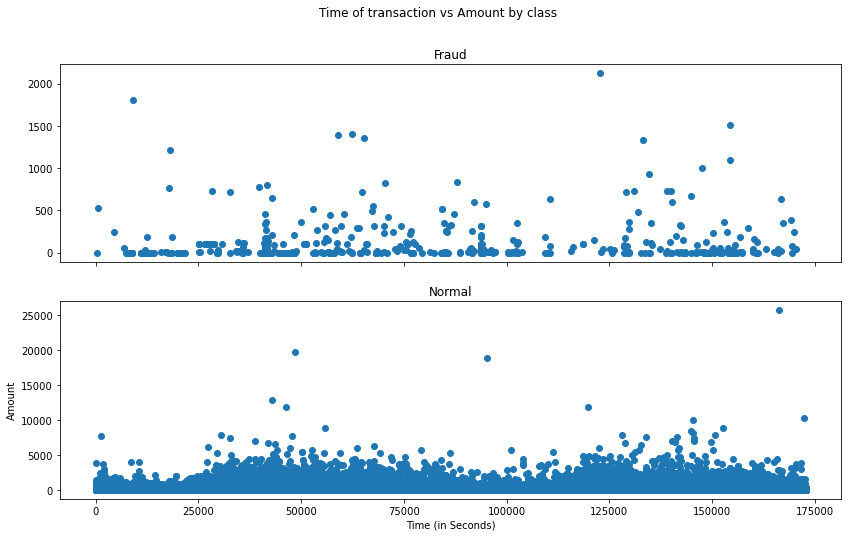

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(Normal.Time, Normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show();

In [16]:
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

In [17]:
#Creamos un rastro
trace = go.Scatter(
    x = Fraud.Time,
    y = Fraud.Amount,
    mode = 'markers'
)
data = [trace]

plotly.offline.iplot({
    "data": data
})

No parece que el momento de la transacción realmente importe para identificar las transacciones fraudulentas.

### Modelado y predicción

In [18]:
data1.shape

(28481, 31)

In [19]:
#Determinamos el número de fraudes y transacciones validas.
Fraud = data1[data1['Class']==1]
Valid = data1[data1['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [20]:
#Imprimimos la cantidad de valores atípicos, el número de casos de fraude y transacciones válidas.
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


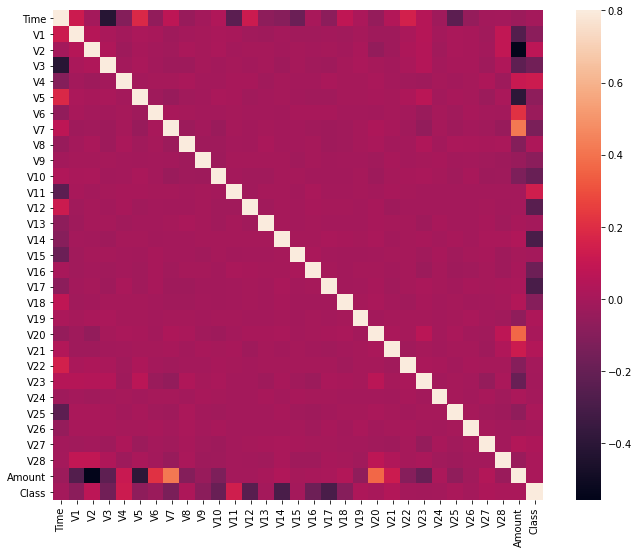

In [21]:
#Matriz de correlación
correlation_matrix = data1.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

La matriz de correlación anterior muestra que ninguno de los componentes de PCA de V1 a V28 tiene correlación entre sí; sin embargo, si observamos que la clase tiene alguna forma de correlaciones positivas y negativas con los componentes de V, pero no tiene correlación con el tiempo y la cantidad.

In [22]:
#Tomamos todas las columnas del dataframe

columns = data1.columns.tolist()
#Filtramos las columnas para borrar los datos que no queremos
columns = [c for c in columns if c not in ["Class"]]
#Guardamos la variable que estamos prediciendo
target = "Class"
#Definimos un estado aleatorio
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Imprimimos las formas de X y Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


## Modelo de predicción (Model Prediction)
Ahora comenzamos a construir el modelo de predicción. Los tipos de algoritmos que vamos a utilizar para intentar hacer la detección de anomalías en este conjunto de datos son:
- Isolation Forest Algorithm: Una de las técnicas más nuevas para detectar anomalías. El algoritmo se basa en el hecho de que las anomalías son puntos de datos que son pocos y diferentes. Como resultado de estas propiedades, las anomalías son susceptibles a un mecanismo llamado "insolation" *(aislamiento)*. Este método es muy útil y es fundamentalmente diferente de todos los métodos existentes. 
Este es un método con un algoritmo de baja complejidad de tiempo lineal y un pequeño requisito de memoria. Construye un modelo de buen rendimiento con una pequeña cantidad de árboles utilizando pequeñas submuestras de tamaño fijo, independientemente del tamaño de un conjunto de datos

Los métodos típicos de aprendizaje automático tienden a funcionar mejor cuando los patrones que intentan aprender están equilibrados, lo que significa que la misma cantidad de buenos y malos comportamientos están presentes en el conjunto de datos.

##### ¿Cómo funciona el algoritmo de Insolation forest?
El algoritmo aísla las observaciones seleccionando aleatoriamente una característica y luego seleccionando aleatoriamente un valor dividido entre los valores máximo y mínimo de la característica seleccionada.

La forma en que el algoritmo construye la separación es creando primero árboles de aislamiento o árboles de decisión aleatorios. Luego, la puntuación se calcula como la longitud de la ruta para aislar la observación.



- Local Outlier Factor (LOF) Algorithm: El algoritmo LOF es un método de detección de valores atípicos no supervisado que calcula la desviación de la densidad local de un punto de datos dado con respecto a sus vecinos.

El número de vecinos considerado (parámetro *n_neighbors*) se elige:
1) Mayor que el número mínimo de objetos que debe contener un clúster, de modo que otros objetos pueden ser valores atípicos locales en relación con este clúster.

2) Más pequeños que el número máximo de cerca de objetos que potencialmente pueden ser valores atípicos locales. En la práctica, esta información generalmente no está disponible, y tomar *n_neighbors = 20* parece funcionar bien en general.




#### Definir los métodos de detección de valores atípicos


In [23]:
#Definimos los métodos de detección de valores atípicos

classifiers={
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
}

#### Aplicar el modelo

In [24]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Isolation Forest":    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



### Conclusiones

- El método del bosque de aislamiento o Insolation forest detectó 73 errores, en cambio, el LOP detectó 97 errores.
- Isolation Forest tiene un 99,74% más de precisión que LOF de 99,65%.
- Al comparar la precisión y recuperación de errores para 2 modelos, el bosque de aislamiento funcionó mucho mejor que el LOF, ya que podemos ver que la detección de casos de fraude es de alrededor del 26% en comparación con la tasa de detección de LOF de solo 2%.
- Por lo tanto, el Método del bosque de aislamiento en general funcionó mucho mejor para determinar los casos de fraude, que es de alrededor del 30%.
- Podemos mejorar esta precisión aumentando el tamaño de la muestra o utilizando algoritmos de deep learning, sin embargo, a costa de gastos computacionales. También podemos utilizar modelos complejos de detección de anomalías para obtener una mayor precisión en la detección de más casos fraudulentos.